In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import pylab
from tqdm import tqdm
%matplotlib inline

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

import warnings
warnings.filterwarnings("ignore")

# Имеется AI по типу ChatGPT. Выпустили обновление, которое должно улучшить выдачу ответов и снизить кол-во нажатий на 'generate answer again' со среднего равного 0.25 до среднего значения равного 0.2 . Необходимо узнать, действительно ли оно работает.

In [63]:
size = 30000 # Кол-во уникальных юзеров данного сервиса
user_id = np.random.choice(size, size, replace=False) # Сгенерирую id пользователей
current_mean = 0.25 # Задам текущее среднее значение
shape = 2 # Форму распределение
scale = current_mean / shape # Scale, чтобы среднее было равно current_mean

gen_again = np.random.gamma(shape, scale=scale, size=size)
data = pd.DataFrame({'user_id': user_id,
                     'gen_again': gen_again})
data.head()

,user_id,gen_again
0,27983,0.181351
1,4934,0.195007
2,14961,0.193341
3,7776,0.239886
4,8680,0.171311


In [64]:
data.gen_again.mean()

0.24830185775504524

count    30000.000000
mean         0.248302
std          0.175058
min          0.000153
25%          0.118763
50%          0.209121
75%          0.335727
max          1.733326
Name: gen_again, dtype: float64


<AxesSubplot:xlabel='gen_again', ylabel='Count'>

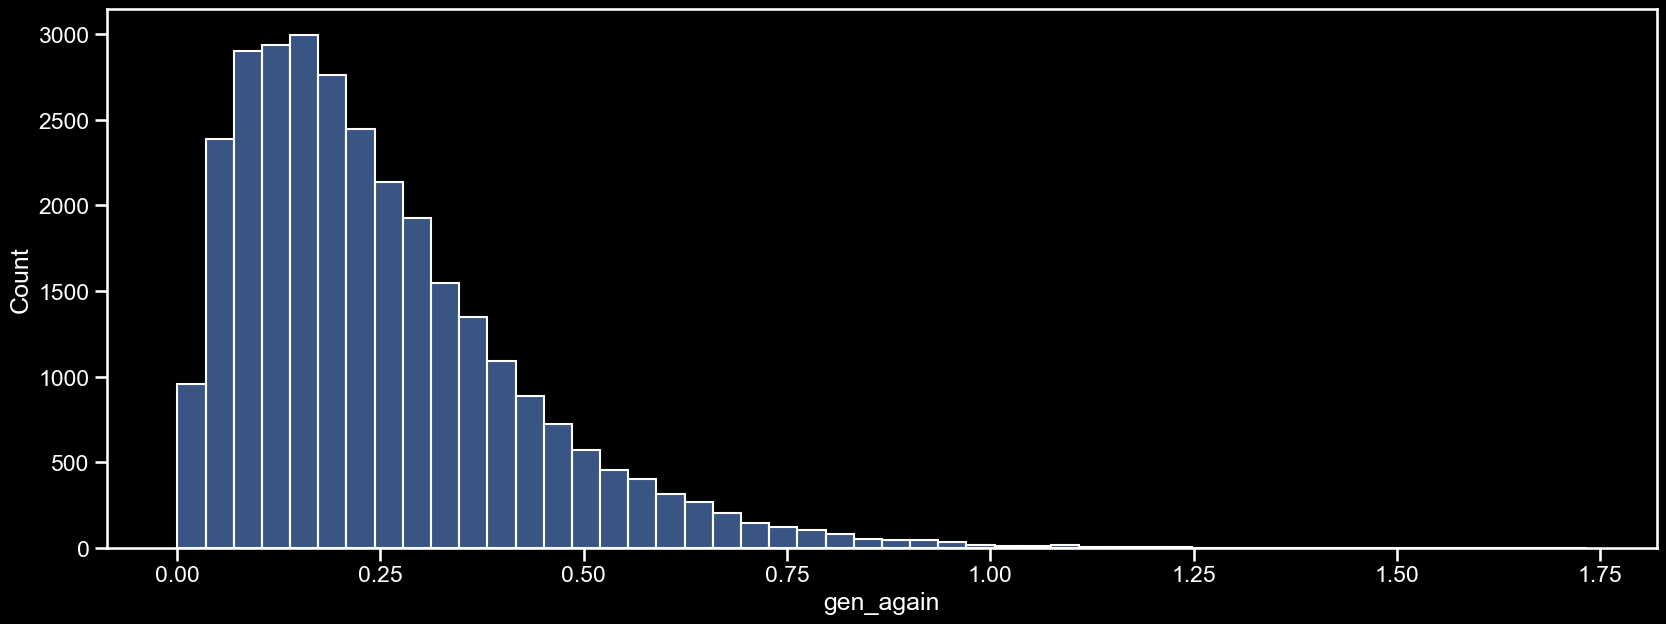

In [65]:
print(data.gen_again.describe())
plt.figure(figsize=(20,7))
sns.histplot(data=data.gen_again, bins=50)

In [66]:
# Рассчитаю время и размер выборки необходимой для проведения A/B теста.

effect_size = sms.proportion_effectsize(0.20, 0.25)
sample_size = round(sms.NormalIndPower().solve_power(effect_size, power=0.9, alpha=0.01, ratio=1)) 

hours = round(sample_size * 2 / 200) # Пусть по условию к нам заходят 200 уникальных юзеров в час.

In [67]:
# Сделаю сплит систему и проведу A/A тест для ее проверки.

def split(uid):
    group = hash(str(uid) + 'hello') % 2
    return 'test' if group else 'control'


t_data = data.sample(5000) # Сделаю выборку, которую разобью на 
t_data['group'] = t_data.user_id.apply(split)
control_group = t_data.query('group == "control"')
test_group = t_data.query('group == "test"')
stats.ttest_ind(control_group.gen_again, test_group.gen_again, equal_var=False)

Ttest_indResult(statistic=0.15836388253282874, pvalue=0.8741764702861903)

Text(0.5, 1.0, 'Test Group')

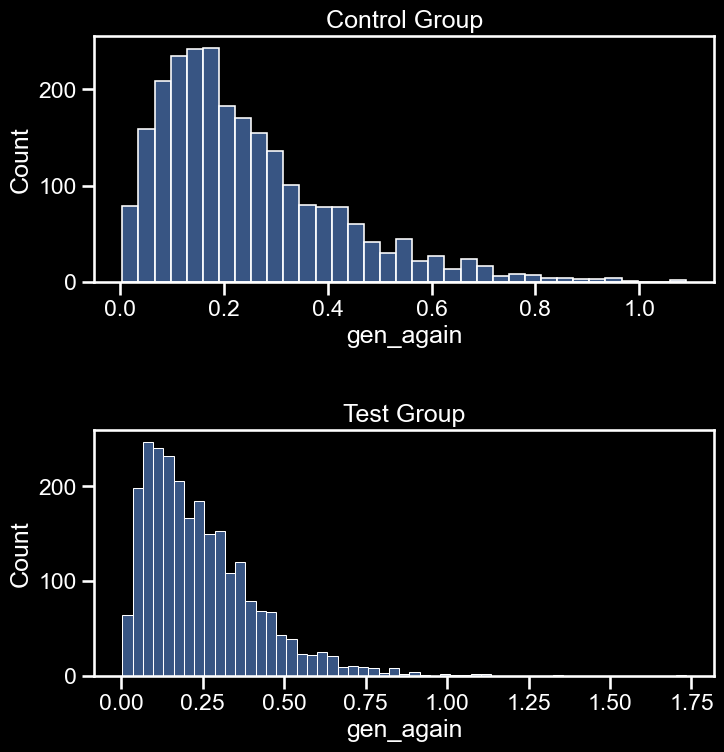

In [68]:
fit, axes = plt.subplots(nrows=2, figsize=(8,8))
plt.subplots_adjust(hspace=0.6, top=0.9, bottom=0.1)
sns.histplot(data=control_group.gen_again, ax=axes[0])
axes[0].set_title('Control Group')
sns.histplot(data=test_group.gen_again, ax=axes[1])
axes[1].set_title('Test Group')

Сплит система работает корректно. Проводим A/B test.

# Условия для применения t-test:  

1) Независимость выборок +  
2) Нормальность распределения средних. Продемонстрирую  
3) Гомогенность дисперсий. Если нет - Уэлч +  
4) Непрерывные значения +  
5) Отсутствие значительных выбросов +  
6) Выборки репрезентативны +  

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7001.18it/s]


Text(0.5, 1.0, 'Means distribution')

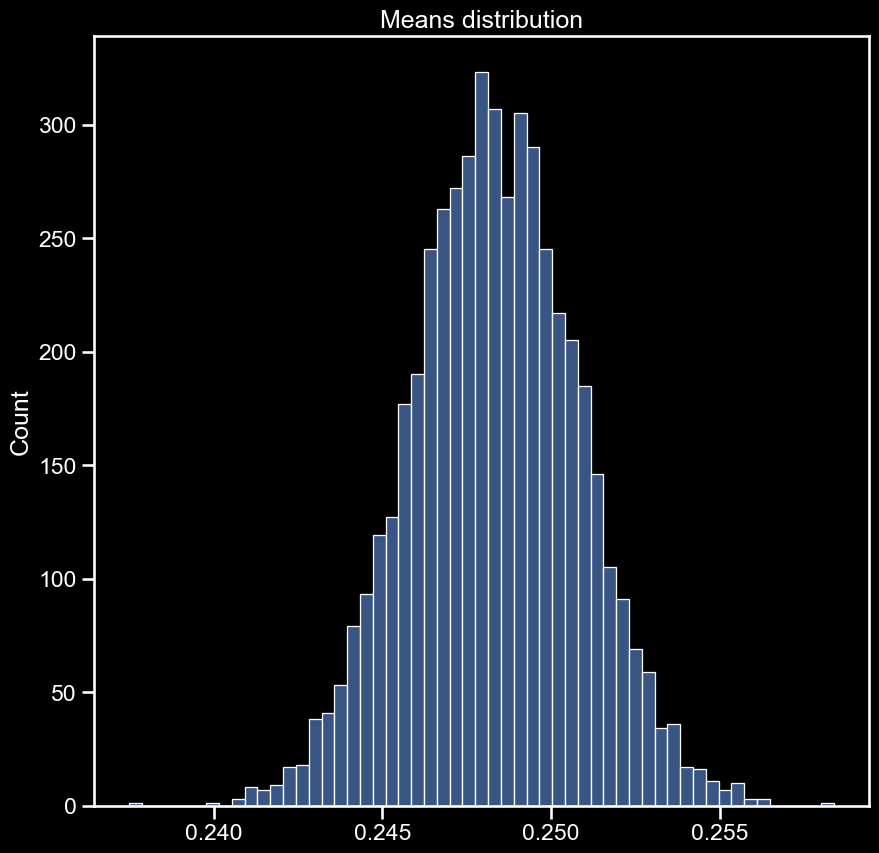

In [69]:
# Проверю распределение средних на нормальность.

means = []
for i in tqdm(range(5000)):
    means.append(data.gen_again.sample(5000, replace=True).mean())
    

sns.histplot(data=means)
plt.title('Means distribution')

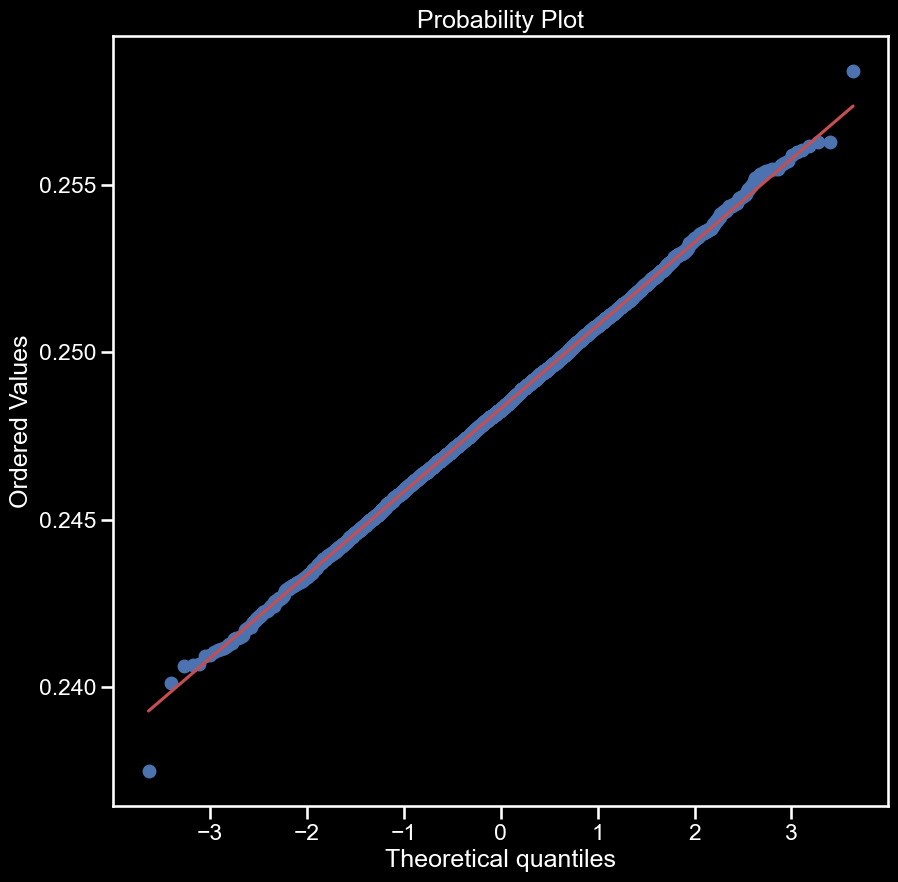

In [70]:
stats.probplot(means, dist='norm', plot=pylab)
pylab.show()

In [82]:
# Средние распределены нормально. Буду использовать Уэлч t-test. "Запускаю" A/B тест.
test_data = pd.DataFrame()
stat_result = pd.DataFrame()

for hour in tqdm(range(hours)):
    new_users = data.sample(200) # Зашли 200 пользователей
    new_users['hour'] = hour # Добавлю час (или дату, если на тест нужны дни)
    new_users['group'] = new_users.user_id.apply(split) # Разбиты на группы
    
    control = new_users.query('group == "control"')
    test = new_users.query('group == "test"')
    
    test.gen_again = test.gen_again.apply(lambda x: x * np.random.uniform(0.55, 1.05)) # Симулирую эффект обновления
    
    test_data = test_data.append(control).append(test) # Собираю в один дата-фрейм
    
    t_test = stats.ttest_ind(test_data.query('group =="control"').gen_again,
                             test_data.query('group=="test"').gen_again, equal_var=False) # Проведу t-test
    
    stat_result = stat_result.append(pd.DataFrame({'t': [t_test[0]], 'p': [t_test[1]], 'hour': hour})) # Запишу результаты теста
    
    stat_by_hour = test_data.groupby(['group', 'hour'], as_index=False).agg({'gen_again': 'mean'})
    

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 88.60it/s]


<AxesSubplot:xlabel='hour', ylabel='gen_again'>

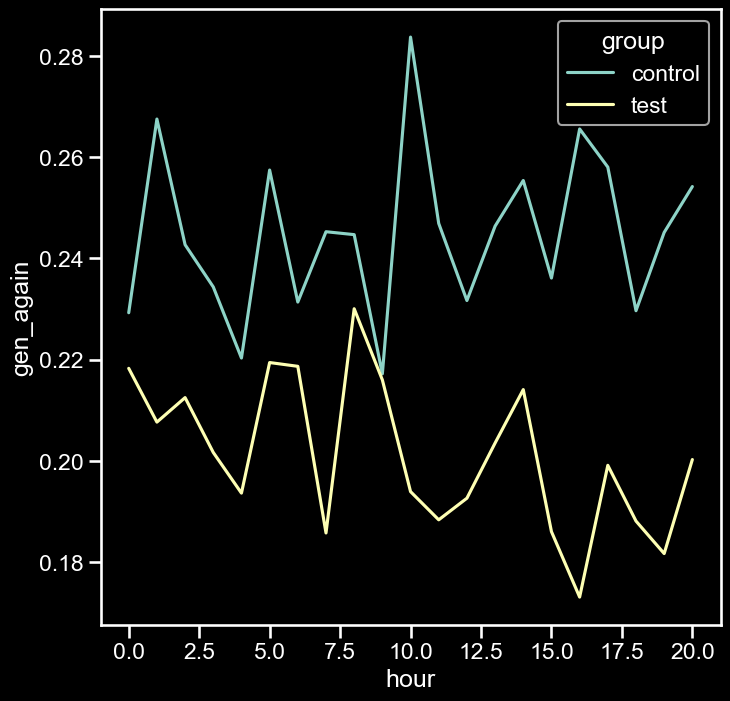

In [83]:
plt.figure(figsize=(8, 8))
sns.lineplot(data=stat_by_hour, x='hour', y='gen_again', hue='group')

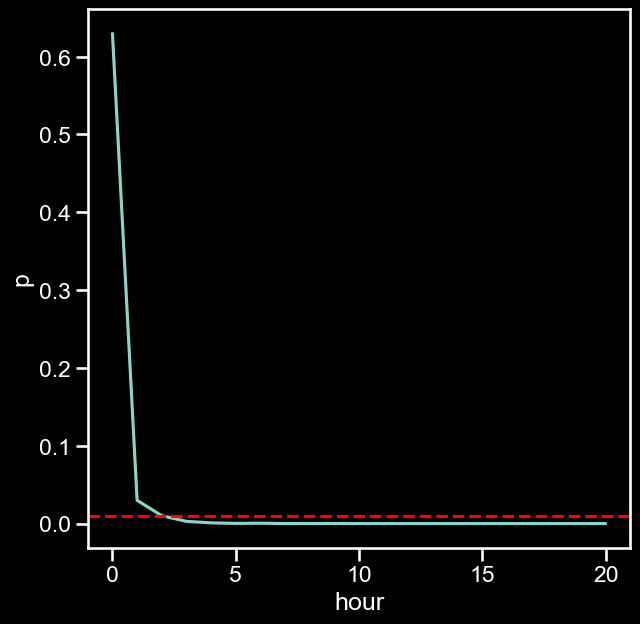

In [84]:
stat_result = stat_result.reset_index()
plt.figure(figsize=(7, 7))
ax = sns.lineplot(data=stat_result, x="hour", y="p")
ax.axhline(0.01, ls='--', color='red')